#### Predicting Temperature Time Series with LSTM

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) that is commonly used for sequence modeling, particularly for processing time-series data. Unlike traditional RNNs, LSTMs have a memory cell that allows them to selectively remember or forget information over time, which makes them particularly useful for long-term dependencies.

In this tutorial, we'll use Pytorch to build an LSTM model that can predict a time-series based on previous data. We'll use numpy and pandas to preprocess the data.

#### Step 1: Import Libraries

We'll start by importing the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

#### Step 2: Load Data
For this tutorial, we'll use a sample dataset that contains temperature readings for a single sensor over time. We'll load the dataset into a pandas DataFrame and preprocess it so that it can be fed into our LSTM model.

In [2]:
# Load data into a pandas DataFrame
df = pd.read_csv('data/temperature.csv')

# Convert the 'datetime' column to a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'datetime' column as the index
df.set_index('Date', inplace=True)

# Resample the data to hourly intervals and fill missing values with the previous value
df = df.resample('H').ffill()

# Normalize the data
df = (df - df.mean()) / df.std()

# Convert the DataFrame to a numpy array
data = df.values
df[:10]

/var/folders/21/25m9bdqj7pv3mhbdjmv2z1w40000gn/T/ipykernel_90151/1258845797.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').ffill()


,Temp
Date,
1981-01-01 00:00:00,2.338143
1981-01-01 01:00:00,2.338143
1981-01-01 02:00:00,2.338143
1981-01-01 03:00:00,2.338143
1981-01-01 04:00:00,2.338143
1981-01-01 05:00:00,2.338143
1981-01-01 06:00:00,2.338143
1981-01-01 07:00:00,2.338143
1981-01-01 08:00:00,2.338143


#### Step 3: Split Data

Next, we'll split the data into training and testing sets. We'll use the first 70% of the data for training and the remaining 30% for testing.

In [3]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.7)
train_data, test_data = data[:train_size], data[train_size:]

#### Step 4: Create Data Sequences
Before we can train our LSTM model, we need to create sequences of data that the model can learn from. We'll create sequences of length 24 (one day), and we'll use a sliding window approach to create overlapping sequences.


# Understanding LSTMs and Sliding Window Technique for Time Series Analysis

Time series analysis represents one of the most challenging domains in machine learning due to the temporal dependencies inherent in sequential data. The sliding window technique and Long Short-Term Memory (LSTM) networks form a powerful combination for addressing these challenges. Let me provide a comprehensive explanation of these concepts and their interrelationships.

## The Sliding Window Technique

The sliding window technique is a fundamental method for transforming sequential data into a format suitable for supervised learning. This approach is particularly valuable in time series forecasting where we aim to predict future values based on historical patterns.

The function `create_sequences()` that you've shared implements this technique by:

1. Taking a time series dataset and a sequence length parameter
2. Creating pairs of input sequences (X) and target values (y)
3. Sliding through the data one step at a time to generate these pairs

To elaborate on the mechanics of the sliding window approach:

For a time series with data points $[x_1, x_2, ..., x_n]$ and a chosen sequence length $k$, the sliding window creates:

- Input sequence: $[x_i, x_{i+1}, ..., x_{i+k-1}]$
- Target value: $x_{i+k}$

Where $i$ ranges from 1 to $n-k$.

The sequence length parameter (in your code, `seq_length = 24`) is crucial as it defines the temporal context the model will use for making predictions. This parameter determines how far back in time the model "looks" to predict the next value. Selecting an appropriate sequence length involves balancing:

- Short windows: May miss longer-term patterns but train faster and require less data
- Long windows: Can capture extended temporal dependencies but increase model complexity and computational requirements

When working with time-based data like hourly temperature readings, a sequence length of 24 would correspond to using a full day's worth of readings to predict the next hour's temperature. This approach allows the model to learn daily cyclical patterns.

## Long Short-Term Memory Networks

LSTMs represent a specialized architecture of Recurrent Neural Networks (RNNs) designed to address the limitations of traditional RNNs, particularly the vanishing gradient problem that hampers learning of long-range dependencies.

### The Vanishing Gradient Challenge

Standard RNNs struggle with learning dependencies over long sequences because gradients tend to either vanish or explode during backpropagation through time. This limitation occurs because errors must propagate backward through many time steps, with multiplicative effects at each step that can cause gradients to become extremely small or large.

### LSTM Architecture

LSTMs address this challenge through a sophisticated cell structure with multiple gating mechanisms that regulate information flow. The LSTM cell architecture consists of:

```mermaid
flowchart TD
    Input["Input<br>x_t, h_t-1"] --> Forget["Forget Gate<br>f_t = σ(W_f·[h_t-1,x_t]+b_f)"]
    Input --> Input_Gate["Input Gate<br>i_t = σ(W_i·[h_t-1,x_t]+b_i)"]
    Input --> Cell_State["Candidate Cell State<br>C̃_t = tanh(W_C·[h_t-1,x_t]+b_C)"]
    Input --> Output_Gate["Output Gate<br>o_t = σ(W_o·[h_t-1,x_t]+b_o)"]
    
    Prev_Cell["Previous Cell State<br>C_t-1"] --> Cell_Update["Cell State Update"]
    Forget --> Cell_Update
    Input_Gate --> Cell_Update
    Cell_State --> Cell_Update
    
    Cell_Update --> New_Cell["New Cell State<br>C_t = f_t * C_t-1 + i_t * C̃_t"]
    New_Cell --> Hidden_Calc["Hidden State Calculation"]
    Output_Gate --> Hidden_Calc
    
    Hidden_Calc --> New_Hidden["New Hidden State<br>h_t = o_t * tanh(C_t)"]
    
    style Input fill:#BCFB89
    style Forget fill:#FBF266
    style Input_Gate fill:#FBF266
    style Cell_State fill:#9AE4F5
    style Output_Gate fill:#FBF266
    style Prev_Cell fill:#9AE4F5
    style Cell_Update fill:#FA756A
    style New_Cell fill:#0096D9
    style Hidden_Calc fill:#FA756A
    style New_Hidden fill:#FCEB14
```

### The Three Gates

1. **Forget Gate**: Determines what information from the previous cell state should be discarded
   - $f_t = \sigma(W_f \cdot [h_t-1, x_t] + b_f)$

2. **Input Gate**: Controls what new information will be stored in the cell state
   - $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$
   - $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$

3. **Output Gate**: Filters the cell state to determine the next hidden state
   - $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$

### Cell State and Hidden State

The cell state ($C_t$) acts as the memory of the LSTM, allowing information to flow unchanged through the network or be selectively modified:

$C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$

The hidden state ($h_t$) represents the output for the current time step and input to the next time step:

$h_t = o_t * \tanh(C_t)$

This architecture enables LSTMs to:
- Retain important information over many time steps
- Forget irrelevant information
- Update the internal state with new inputs
- Control what information is exposed as output

# Explaining LSTM Gate Equations and Activation Functions

Let me provide a detailed explanation of the LSTM gate equations, what each parameter represents, and the rationale behind the choice of activation functions.

## LSTM Gate Equations with Parameter Explanations

### Forget Gate

$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$

- $f_t$: Output of the forget gate at time step $t$ (a vector with values between 0 and 1)
- $W_f$: Weight matrix for the forget gate (learned during training)
- $h_{t-1}$: Hidden state from the previous time step (contains information from past sequence)
- $x_t$: Input at the current time step
- $[h_{t-1}, x_t]$: Concatenation of the previous hidden state and current input
- $b_f$: Bias vector for the forget gate
- $\sigma$: Sigmoid activation function that outputs values between 0 and 1

The forget gate determines which information from the previous cell state should be retained (values close to 1) or discarded (values close to 0). Each element in the output vector corresponds to a dimension in the cell state.

### Input Gate

$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$

- $i_t$: Output of the input gate at time step $t$ (a vector with values between 0 and 1)
- $W_i$: Weight matrix for the input gate
- $b_i$: Bias vector for the input gate

The input gate controls how much of the new candidate values should be added to the cell state.

### Candidate Cell State

$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$

- $\tilde{C}_t$: Candidate cell state at time step $t$ (a vector with values between -1 and 1)
- $W_C$: Weight matrix for the candidate cell state
- $b_C$: Bias vector for the candidate cell state
- $\tanh$: Hyperbolic tangent activation function that outputs values between -1 and 1

The candidate cell state represents the new information that might be added to the cell state, regulated by the input gate.

### Output Gate

$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$

- $o_t$: Output of the output gate at time step $t$ (a vector with values between 0 and 1)
- $W_o$: Weight matrix for the output gate
- $b_o$: Bias vector for the output gate

The output gate determines what information from the cell state should be exposed to the next layer or time step.

### Cell State Update

$C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$

- $C_t$: Cell state at time step $t$
- $C_{t-1}$: Cell state from the previous time step
- $*$: Element-wise multiplication (Hadamard product)

The cell state update equation combines:
1. What to keep from the previous cell state ($f_t * C_{t-1}$)
2. What new information to add ($i_t * \tilde{C}_t$)

### Hidden State Update

$h_t = o_t * \tanh(C_t)$

- $h_t$: Hidden state at time step $t$
- $\tanh(C_t)$: Cell state transformed to values between -1 and 1

The hidden state is created by filtering the cell state through the output gate.

## Why Choose tanh Activation Function?

The choice of tanh for the candidate cell state ($\tilde{C}_t$) and for transforming the cell state is deliberate and serves several important purposes:

1. **Output Range**: The tanh function outputs values between -1 and 1, allowing the network to express both positive and negative influences. This is crucial for modeling complex patterns where some inputs may need to increase certain values while others decrease them.

2. **Zero-Centered Output**: Unlike the sigmoid function which outputs values between 0 and 1 (with a mean of 0.5), tanh outputs are centered around zero. This property helps mitigate the vanishing gradient problem by allowing for both positive and negative gradients during backpropagation.

3. **Steeper Gradient**: The tanh function has a steeper gradient compared to sigmoid, which means it can produce stronger signals and can learn more quickly in certain situations.

4. **Normalization Effect**: Using tanh helps keep the cell state values normalized, preventing them from growing too large over many time steps. This contributes to numerical stability during training.

5. **Complementary to Sigmoid Gates**: The combination of sigmoid for gates (determining what to keep/discard) and tanh for content (determining potential new values) creates a powerful mechanism for selective memory. Sigmoid outputs between 0-1 act as "how much to keep," while tanh outputs between -1 and 1 represent "what values to consider."

When the tanh function is applied to the cell state in the hidden state calculation ($h_t = o_t * \tanh(C_t)$), it serves to normalize the cell state values to the range [-1, 1] before being filtered by the output gate. This helps ensure that the hidden state remains within a consistent range, making it easier for subsequent layers to process.

The sigmoid function, on the other hand, is used in all gates because they need to make binary decisions about what information to keep or discard. Values close to 0 mean "discard," and values close to 1 mean "keep," which aligns perfectly with the gate control mechanism.

This carefully designed combination of activation functions allows LSTMs to effectively learn long-term dependencies in sequential data, addressing the limitations of traditional RNNs.

## Application to Your LSTM Implementation

In your code snippet:

```python
seq_length = 24  # Using 24 time steps
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)
```

You're preparing data for an LSTM model by:

1. Setting a sequence length of 24, which defines the temporal context
2. Generating training sequences where each input is 24 consecutive time steps
3. Setting each target as the value immediately following its input sequence

After this preprocessing, your LSTM model will learn to recognize patterns within these 24-step windows to predict the next value. The LSTM's ability to selectively retain or forget information makes it particularly well-suited for this task, as it can:

- Learn seasonal patterns (like daily temperature cycles)
- Identify trends over multiple time steps
- Remember important events from earlier in the sequence
- Ignore irrelevant fluctuations

When choosing parameters for your LSTM model, consider:

1. **Number of LSTM units**: More units increase capacity but require more data and computational resources
2. **Number of stacked LSTM layers**: Multiple layers can learn hierarchical temporal features
3. **Dropout rate**: To prevent overfitting, especially with limited data
4. **Learning rate**: Typically lower learning rates work better for complex time series

## Advanced Considerations

For sophisticated time series modeling, consider these extensions:

1. **Bidirectional LSTMs**: Process sequences in both forward and backward directions to capture additional context
2. **Attention mechanisms**: Allow the model to focus on different parts of the input sequence when making predictions
3. **Stateful LSTMs**: Maintain state between batches for very long-range dependencies
4. **Hybrid models**: Combine LSTMs with CNNs or traditional statistical methods

The sliding window approach paired with LSTM networks provides a powerful framework for time series forecasting, capable of capturing complex temporal patterns while addressing the challenges inherent in sequential data analysis.

In [4]:
# Function to create sequences of data
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    
    return np.array(X), np.array(y)

# Create sequences for training and testing data
seq_length = 24
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

### Step 5: Create LSTM Model
Now, we'll create our LSTM model using Pytorch. Our model will have one LSTM layer with 32 hidden units and one fully connected output layer.

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In the ``__init__`` method, we define an LSTM layer with hidden_size hidden units and a fully connected output layer with output_size output units. In the forward method, we pass the input `x` through the LSTM layer, take the output of the last time step, and pass it through the fully connected output layer.

### Step 6: Instantiate Model and Define Loss Function and Optimizer
Now, we'll instantiate our LSTM model, define our loss function (mean squared error), and define our optimizer (Adam).

In [6]:
# Instantiate the model
input_size = X_train.shape[2]
hidden_size = 32
output_size = 1
model = LSTM(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Step 7: Train the Model
Next, we'll train our LSTM model on the training data. We'll use a batch size of 32 and train for 50 epochs.

In [7]:
# Convert numpy arrays to Pytorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


# Define the batch size and number of epochs
batch_size = 32
num_epochs = 25

# Train the model
for epoch in range(num_epochs):
    # Shuffle the training data
    perm = torch.randperm(X_train.shape[0])
    X_train = X_train[perm]
    y_train = y_train[perm]

    # Loop over batches
    for i in range(0, X_train.shape[0], batch_size):
        # Get batch
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print loss for this epoch
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/25], Loss: 0.0007
Epoch [2/25], Loss: 0.0005
Epoch [3/25], Loss: 0.0008
Epoch [4/25], Loss: 0.0001
Epoch [5/25], Loss: 0.0000
Epoch [6/25], Loss: 0.0002
Epoch [7/25], Loss: 0.3496
Epoch [8/25], Loss: 0.0000
Epoch [9/25], Loss: 0.0001
Epoch [10/25], Loss: 0.0000
Epoch [11/25], Loss: 0.0009
Epoch [12/25], Loss: 0.0008
Epoch [13/25], Loss: 0.0003
Epoch [14/25], Loss: 0.0006
Epoch [15/25], Loss: 0.7127
Epoch [16/25], Loss: 0.0000
Epoch [17/25], Loss: 0.0003
Epoch [18/25], Loss: 0.0000
Epoch [19/25], Loss: 0.0000
Epoch [20/25], Loss: 0.0000
Epoch [21/25], Loss: 0.0002
Epoch [22/25], Loss: 0.0000
Epoch [23/25], Loss: 0.0001
Epoch [24/25], Loss: 0.0007
Epoch [25/25], Loss: 0.0004


### Step 8: Evaluate the Model
Finally, we'll evaluate our LSTM model on the testing data.

In [8]:
# Evaluate the model on the test data
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Calculate the test loss
test_loss = criterion(y_pred, y_test)
print('Test Loss: {:.4f}'.format(test_loss.item()))

Test Loss: 0.0168


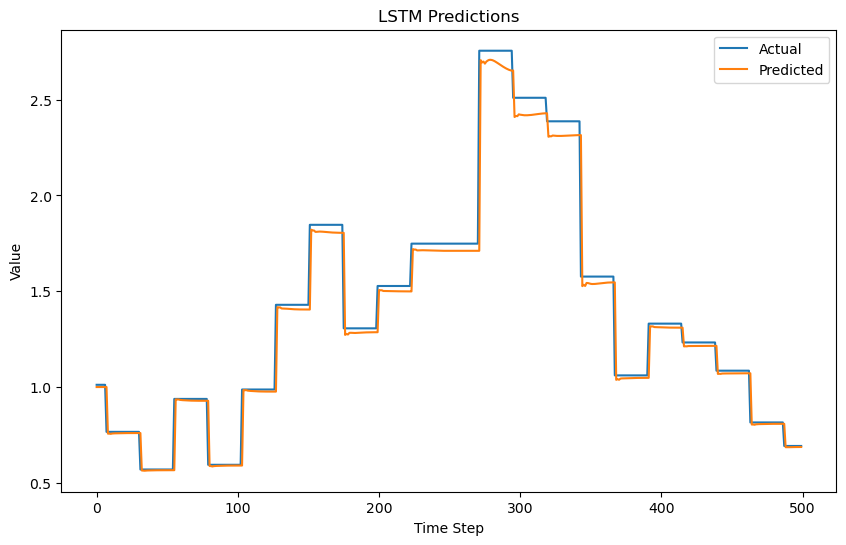

In [9]:
import matplotlib.pyplot as plt

# Convert Pytorch tensors to numpy arrays
y_test = y_test.numpy()
y_pred = y_pred.numpy()

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test[:500], label='Actual')
plt.plot(y_pred[:500], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('LSTM Predictions')
plt.legend()
plt.show()

##### Interpretation of the LSTM prediction performance

The orange line (predicted values) follows the blue line (actual values) remarkably closely throughout the entire time series. This close tracking indicates that your LSTM model has successfully captured both:

1. The overall pattern of the time series (the general upward and downward trends)
2. The specific step changes that occur throughout the data

Several aspects are particularly impressive:

- The model accurately predicts the sharp transitions between different levels in the data, which is typically challenging for prediction models
- There is minimal lag in the predictions, meaning your model is responding quickly to changes in the underlying pattern
- The prediction errors appear consistently small across both high and low values in the series
- The model performs well across the entire test set, not just in certain regions

What makes this especially noteworthy is that the data appears to have discrete level shifts rather than smooth transitions. These abrupt changes are typically more difficult to predict than smooth patterns because they require the model to recognize precise triggering conditions rather than just following gradual trends.

The few small discrepancies:

- Around time step 275-290, there's a slight underprediction at the peak
- At a few transition points, the model shows minor overshooting or undershooting before quickly correcting
- Some of the flat regions show tiny oscillations in the predicted values

These minor imperfections are normal and expected even in well-performing models. Overall, this appears to be a successful implementation of an LSTM for this particular time series forecasting task.

##### Future Improvements

- Experimenting with different sequence lengths
- Adding more LSTM layers or increasing the number of units
- Incorporating attention mechanisms to better handle the abrupt transitions

But given the current performance, these optimizations would likely yield only marginal improvements to what is already a very good model.